In [266]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [267]:
class TreeNode(object):
    def __init__(self, feature_i=None, threshold=None, value=None, child=None):
        self.feature_i = feature_i
        self.threshold = threshold
        self.value = value
        self.child = child

def divide_feature_index(X, feature_i, threshold):
    if isinstance(threshold.item(), int) or isinstance(threshold.item(), float):
        true_index = X[:,feature_i]>=threshold
        false_index = X[:,feature_i]<threshold
    else:
        true_index = X[:,feature_i]==threshold
        false_index = X[:,feature_i]!=threshold
    return true_index, false_index

In [268]:
class DecisionTree(object):
    def __init__(self, max_depth=float("inf"), min_samples_split=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self._purity_calc = None
        self._leaf_calc_value = None
    
    def fit(self, X, y):   
        if len(X.shape)==1:
            X = np.expand_dims(X, axis=1)        
        self.root = self._build_tree(X,y,0)
    
    def _build_tree(self, X, y, depth):
        if len(X.shape)==1:
            X = np.expand_dims(X, axis=1)    
        m,n = X.shape
        label_value = np.unique(y)
        
        #只有1个类别，
        if len(label_value)==1:
            return TreeNode(value=label_value[0])
        
        #最大深度、叶子节点上样本数量条件
        if depth==self.max_depth or m<=self.min_samples_split:
            return TreeNode(value=self._leaf_calc_value(y))

        max_purity = None
        for i in range(n):
            feature_value = np.unique(X[:,i])
            for threshold in feature_value:
                true_index, false_index = divide_feature_index(X, i, threshold)
                if sum(true_index)>0 and sum(false_index)>0:
                    ytrue = y[true_index]
                    yfalse = y[false_index]
                    
                    purity = self._purity_calc(y, X[:,i], ytrue, yfalse)
                    if max_purity is None or purity>max_purity:
                        max_purity = purity
                        decision = {"feature_index":i, "threshold":threshold}
                        divided = {"TrueX": X[true_index], "Truey":ytrue,
                                   "FalseX":X[false_index],"Falsey":yfalse}
                        
        node = TreeNode(feature_i=decision["feature_index"], threshold=decision["threshold"])
        node.child = [self._build_tree(divided["TrueX"], divided["Truey"], depth+1),
                      self._build_tree(divided["FalseX"], divided["Falsey"],depth+1) 
                     ]
        return node
        
    def predict(self, X):
        return [self._predict(x) for x in X]
    
    def _predict(self, x):
        ptr = self.root
        while ptr.value is None :
            next_ptr = ptr.child[1]
            feature_value = x[ptr.feature_i]
            if isinstance(feature_value, int) or isinstance(feature_value, float):
                if feature_value >= ptr.threshold:
                    next_ptr = ptr.child[0]
            elif feature_value == ptr.threshold:
                next_ptr = ptr.child[0]
            ptr = next_ptr
        return ptr.value

In [269]:
def calculate_entropy(y):
    unique_labels = np.unique(y)
    entropy = 0
    for yi in unique_labels:
        count = sum(y == yi)
        p = count / len(y)
        entropy += -p * np.log2(p)
    return entropy

def calculate_gini(y):
    unique_labels = np.unique(y)
    gini = 1
    for yi in unique_labels:
        count = sum(y == yi)
        p = count / len(y)
        gini -= p**2
    return gini


class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, x, y1, y2):
        # Calculate information gain
        p = len(y1)/len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p*calculate_entropy(y1)-(1-p)*calculate_entropy(y2)
        info_gain_rate = info_gain/calculate_entropy(x)
        return info_gain_rate
    
    def _calculate_gini(self, y, x, y1, y2):
        p = len(y1)/len(y)
        Gyx = p*calculate_gini(y1) + (1-p)*calculate_gini(y2)
        return -Gyx
    
    def _most_vote(self, y):
        label_value = np.unique(y)
        return label_value[np.argmax([sum(y==yi) for yi in label_value])]

    def fit(self, X, y):
        #self._purity_calc = self._calculate_information_gain
        self._purity_calc = self._calculate_gini
        self._leaf_calc_value = self._most_vote
        super(ClassificationTree, self).fit(X, y)

In [270]:
class RegressionTree(DecisionTree):
    def _calculate_square_error(self, y, x, y1, y2):
        #print(y1,y2)
        S = np.std(y1)**2*len(y1) + np.std(y2)**2*len(y2)
        
        return -S
    
    def _mean_value(self, y):
        return np.mean(y)

    def fit(self, X, y):
        self._purity_calc = self._calculate_square_error
        self._leaf_calc_value = self._mean_value
        super(RegressionTree, self).fit(X, y)

Accuracy: 0.95


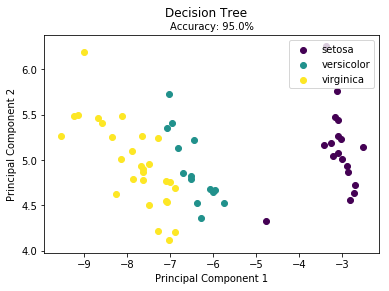

In [271]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = datasets.load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = ClassificationTree()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy:", accuracy)


Plot().plot_in_2d(X_test, y_pred,
        title="Decision Tree",
        accuracy=accuracy,
legend_labels=data.target_names)

In [272]:
x = np.arange(10)+1
x = x.reshape([-1,1])
y = np.array([5.56,5.7,5.91,6.4,6.8,7.05,8.9,8.7,9,9.05])

clf = RegressionTree(max_depth=5)
clf.fit(x,y)

X = np.linspace(0,11,50).reshape([-1,1])
y_pred = clf.predict(X)

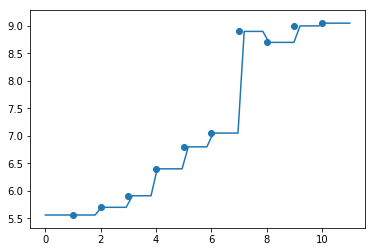

In [273]:
plt.figure()
plt.plot(X.squeeze(), y_pred, '-')
plt.scatter(x,y)

In [36]:
import numpy as np
import math
import sys


def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy


def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse


def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance


def calculate_std_dev(X):
    """ Calculate the standard deviations of the features in dataset X """
    std_dev = np.sqrt(calculate_variance(X))
    return std_dev


def euclidean_distance(x1, x2):
    """ Calculates the l2 distance between two vectors """
    distance = 0
    # Squared distance between each coordinate
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return math.sqrt(distance)


def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy


def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)

In [37]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

#from utils.data_operation import calculate_covariance_matrix
#from utils.data_operation import calculate_correlation_matrix
#from utils.data_manipulation import standardize

bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()

In [47]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = datasets.load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = ClassificationTree()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print(y_pred)
#accuracy = accuracy_score(y_test, y_pred)
#print ("Accuracy:", accuracy)


'''Plot().plot_in_2d(X_test, y_pred,
        title="Decision Tree",
        accuracy=accuracy,
legend_labels=data.target_names)'''

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


'Plot().plot_in_2d(X_test, y_pred,\n        title="Decision Tree",\n        accuracy=accuracy,\nlegend_labels=data.target_names)'